<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/cabai_rawit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7fedc47bc550>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.cabai_rawit.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


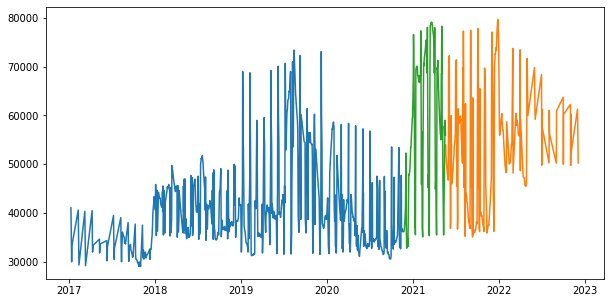

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [10]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_cabairawit_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 30s 422ms/step - loss: 0.0700 - mae: 0.2041 - mape: 90.2799 - val_loss: 0.3919 - val_mae: 0.5724 - val_mape: 93.4467
Epoch 2/30
44/44 [==============================] - 8s 186ms/step - loss: 0.0542 - mae: 0.1645 - mape: 62.4076 - val_loss: 0.3452 - val_mae: 0.5307 - val_mape: 82.4579
Epoch 3/30
44/44 [==============================] - 8s 186ms/step - loss: 0.0444 - mae: 0.1395 - mape: 50.3611 - val_loss: 0.3155 - val_mae: 0.5050 - val_mape: 79.4861
Epoch 4/30
44/44 [==============================] - 8s 185ms/step - loss: 0.0381 - mae: 0.1259 - mape: 49.5768 - val_loss: 0.2899 - val_mae: 0.4817 - val_mape: 76.8153
Epoch 5/30
44/44 [==============================] - 8s 187ms/step - loss: 0.0341 - mae: 0.1213 - mape: 55.1702 - val_loss: 0.2709 - val_mae: 0.4655 - val_mape: 76.2883
Epoch 6/30
44/44 [==============================] - 8s 186ms/step - loss: 0.0313 - mae: 0.1197 - mape: 60.5093 - val_loss: 0.2577 - val_mae: 0.4538 - val_mape:

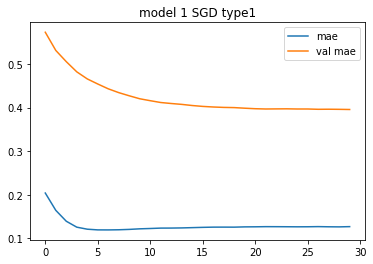

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 23ms/step
13461.593 22.620752 17015.36811238593


,date,actual,prediction
0,2021-05-20,53950,39591.996094
1,2021-05-21,51650,39617.121094
2,2021-05-24,49750,39640.718750
3,2021-05-25,49100,39666.558594
4,2021-05-27,48050,39719.750000
...,...,...,...
229,2022-11-02,49750,40601.523438
230,2022-11-03,60250,40676.054688
231,2022-11-04,52400,40611.691406
232,2022-12-01,61300,40682.410156


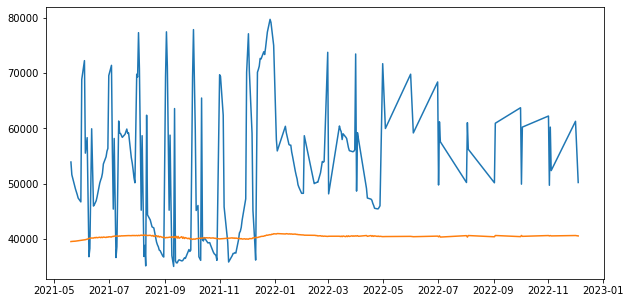

In [ ]:
prediction = forecast_predict(model, test_cabairawit_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_cabairawit = pd.DataFrame()
data_new_cabairawit['date'] = y_test
data_new_cabairawit['actual'] = x_test
data_new_cabairawit['prediction'] = data_result
data_new_cabairawit.to_csv('cabairawit_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_cabairawit.date, data_new_cabairawit.actual)
plt.plot(data_new_cabairawit.date, data_new_cabairawit.prediction)
data_new_cabairawit

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0400 - mae: 0.1567 - mape: 86.1348 - val_loss: 0.1543 - val_mae: 0.3465 - val_mape: 74.9679
Epoch 2/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0386 - mae: 0.1559 - mape: 88.8263 - val_loss: 0.1530 - val_mae: 0.3451 - val_mape: 75.0816
Epoch 3/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0384 - mae: 0.1552 - mape: 87.9090 - val_loss: 0.1512 - val_mae: 0.3430 - val_mape: 75.1289
Epoch 4/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0381 - mae: 0.1539 - mape: 87.1175 - val_loss: 0.1460 - val_mae: 0.3366 - val_mape: 75.2499
Epoch 5/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0372 - mae: 0.1528 - mape: 86.1949 - val_loss: 0.1454 - val_mae: 0.3361 - val_mape: 75.3498
Epoch 6/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0370 - mae: 0.1522 - mape: 85.8991 - val_loss: 0.1407 - val_mae: 0.3308 

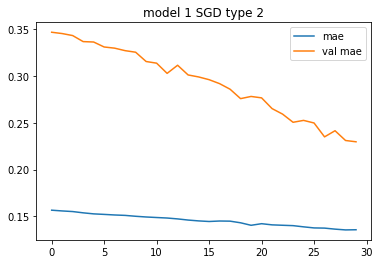

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 9ms/step
10131.911 17.841564 13219.388185540207


,date,actual,prediction
0,2021-05-20,53950,39591.996094
1,2021-05-21,51650,39617.121094
2,2021-05-24,49750,39640.718750
3,2021-05-25,49100,39666.558594
4,2021-05-27,48050,39719.750000
...,...,...,...
229,2022-11-02,49750,40601.523438
230,2022-11-03,60250,40676.054688
231,2022-11-04,52400,40611.691406
232,2022-12-01,61300,40682.410156


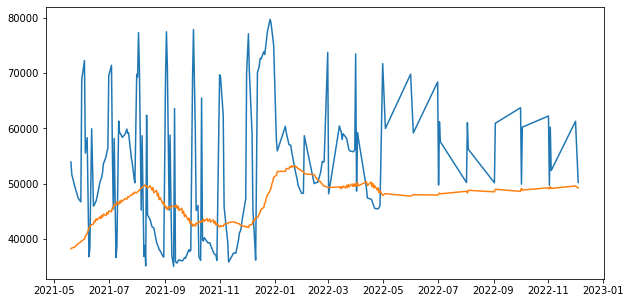

In [ ]:
win_size1 = 60
test_cabairawit_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_cabairawit_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_cabairawit_1 = pd.DataFrame()
data_new_cabairawit_1['actual'] = x_test
data_new_cabairawit_1['prediction'] = data_result_1
data_new_cabairawit_1.to_csv('cabairawit_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabairawit_1.actual)
plt.plot(y_test, data_new_cabairawit_1.prediction)
data_new_cabairawit

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 11s 125ms/step - loss: 0.0411 - mae: 0.1573 - mape: 82.3737 - val_loss: 0.0720 - val_mae: 0.2198 - val_mape: 84.7283
Epoch 2/30
84/84 [==============================] - 11s 124ms/step - loss: 0.0404 - mae: 0.1574 - mape: 84.1871 - val_loss: 0.0712 - val_mae: 0.2182 - val_mape: 85.0915
Epoch 3/30
84/84 [==============================] - 11s 125ms/step - loss: 0.0403 - mae: 0.1601 - mape: 88.8556 - val_loss: 0.0705 - val_mae: 0.2168 - val_mape: 85.5277
Epoch 4/30
84/84 [==============================] - 11s 125ms/step - loss: 0.0402 - mae: 0.1595 - mape: 88.3308 - val_loss: 0.0703 - val_mae: 0.2164 - val_mape: 85.6467
Epoch 5/30
84/84 [==============================] - 11s 125ms/step - loss: 0.0401 - mae: 0.1601 - mape: 89.4768 - val_loss: 0.0702 - val_mae: 0.2161 - val_mape: 85.7449
Epoch 6/30
84/84 [==============================] - 11s 124ms/step - loss: 0.0400 - mae: 0.1598 - mape: 89.2991 - val_loss: 0.0700 - val_mae: 0.2157 - val_

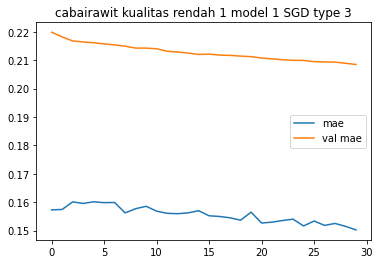

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('cabairawit kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 11ms/step
9782.398 18.142593 12361.52547220609


,actual,prediction
0,53950,38162.289062
1,51650,38314.015625
2,49750,38475.144531
3,49100,38687.429688
4,48050,39015.644531
...,...,...
229,49750,53148.312500
230,60250,53603.246094
231,52400,53244.730469
232,61300,53777.753906


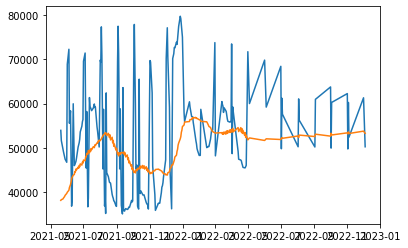

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_cabairawit_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_cabairawit_2 = pd.DataFrame()
# data_new_cabairawit1['date'] = date_test
data_new_cabairawit_2['actual'] = x_test
data_new_cabairawit_2['prediction'] = data_result_2
data_new_cabairawit_2.to_csv('cabairawit_model1_sgd_type3')

plt.plot(y_test, data_new_cabairawit_2.actual)
plt.plot(y_test, data_new_cabairawit_2.prediction)
data_new_cabairawit_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 13s 213ms/step - loss: 0.0719 - mae: 0.2090 - mape: 94.5981 - val_loss: 0.3841 - val_mae: 0.5653 - val_mape: 91.3271
Epoch 2/30
44/44 [==============================] - 8s 190ms/step - loss: 0.0537 - mae: 0.1657 - mape: 64.4138 - val_loss: 0.2869 - val_mae: 0.4790 - val_mape: 76.7069
Epoch 3/30
44/44 [==============================] - 9s 192ms/step - loss: 0.0354 - mae: 0.1217 - mape: 50.7425 - val_loss: 0.1457 - val_mae: 0.3348 - val_mape: 75.0775
Epoch 4/30
44/44 [==============================] - 8s 191ms/step - loss: 0.0239 - mae: 0.1155 - mape: 82.7129 - val_loss: 0.1032 - val_mae: 0.2788 - val_mape: 78.6839
Epoch 5/30
44/44 [==============================] - 8s 189ms/step - loss: 0.0225 - mae: 0.1096 - mape: 77.8062 - val_loss: 0.0971 - val_mae: 0.2683 - val_mape: 79.3352
Epoch 6/30
44/44 [==============================] - 8s 188ms/step - loss: 0.0223 - mae: 0.1118 - mape: 82.0841 - val_loss: 0.0917 - val_mae: 0.2580 - val_mape:

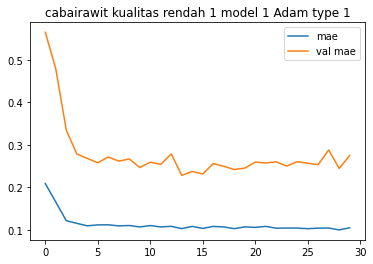

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('cabairawit kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 22ms/step
12019.787 20.772627 15484.648397687304


,actual,prediction
0,53950,35184.730469
1,51650,35174.902344
2,49750,35270.898438
3,49100,35351.339844
4,48050,35433.871094
...,...,...
229,49750,49324.789062
230,60250,49040.398438
231,52400,49249.753906
232,61300,49011.664062


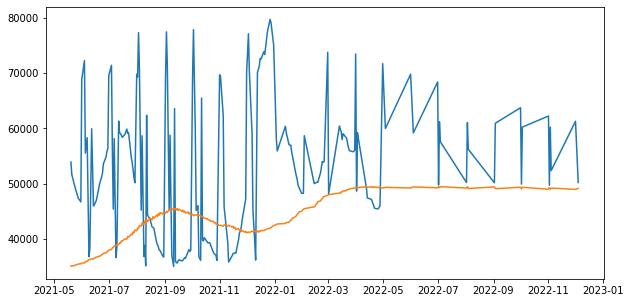

In [ ]:
prediction_a = forecast_predict(model_a, test_cabairawit_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_cabairawit_a = pd.DataFrame()
# data_new_cabairawit1['date'] = date_test
data_new_cabairawit_a['actual'] = x_test
data_new_cabairawit_a['prediction'] = data_result_a
data_new_cabairawit_a.to_csv('cabairawit_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_cabairawit_a.actual)
plt.plot(y_test, data_new_cabairawit_a.prediction)
data_new_cabairawit_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0322 - mae: 0.1349 - mape: 72.3081 - val_loss: 0.0946 - val_mae: 0.2661 - val_mape: 80.2326
Epoch 2/30
718/718 [==============================] - 26s 36ms/step - loss: 0.0312 - mae: 0.1354 - mape: 73.1098 - val_loss: 0.0815 - val_mae: 0.2410 - val_mape: 82.4615
Epoch 3/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0308 - mae: 0.1340 - mape: 72.4220 - val_loss: 0.0727 - val_mae: 0.2219 - val_mape: 85.4009
Epoch 4/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0303 - mae: 0.1326 - mape: 72.0568 - val_loss: 0.0764 - val_mae: 0.2324 - val_mape: 84.2996
Epoch 5/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0304 - mae: 0.1334 - mape: 71.9686 - val_loss: 0.0784 - val_mae: 0.2384 - val_mape: 84.0870
Epoch 6/30
718/718 [==============================] - 26s 36ms/step - loss: 0.0309 - mae: 0.1357 - mape: 73.0243 - val_loss: 0.0653 - val_mae: 0.2054 

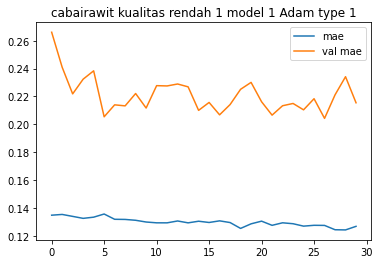

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('cabairawit kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 6ms/step
9173.727 16.568714 11892.525383618065


,actual,prediction
0,53950,38177.839844
1,51650,38145.605469
2,49750,39188.601562
3,49100,39122.832031
4,48050,40171.460938
...,...,...
229,49750,51042.414062
230,60250,51947.687500
231,52400,50355.410156
232,61300,52276.003906


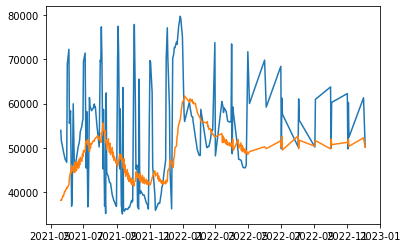

In [ ]:
prediction_a1 = forecast_predict(model_a, test_cabairawit_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_cabairawit_a1 = pd.DataFrame()
data_new_cabairawit_a1['actual'] = x_test
data_new_cabairawit_a1['prediction'] = data_result_a1
data_new_cabairawit_a1.to_csv('cabairawit_model1_adam_type2.csv')

plt.plot(y_test, data_new_cabairawit_a1.actual)
plt.plot(y_test, data_new_cabairawit_a1.prediction)
data_new_cabairawit_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 11s 127ms/step - loss: 0.0359 - mae: 0.1424 - mape: 74.0478 - val_loss: 0.0604 - val_mae: 0.1975 - val_mape: 92.4950
Epoch 2/30
84/84 [==============================] - 11s 127ms/step - loss: 0.0355 - mae: 0.1451 - mape: 81.4828 - val_loss: 0.0604 - val_mae: 0.1961 - val_mape: 93.8735
Epoch 3/30
84/84 [==============================] - 11s 128ms/step - loss: 0.0351 - mae: 0.1431 - mape: 79.7672 - val_loss: 0.0606 - val_mae: 0.1954 - val_mape: 95.0319
Epoch 4/30
84/84 [==============================] - 11s 127ms/step - loss: 0.0350 - mae: 0.1419 - mape: 78.0433 - val_loss: 0.0606 - val_mae: 0.1951 - val_mape: 95.4438
Epoch 5/30
84/84 [==============================] - 11s 128ms/step - loss: 0.0349 - mae: 0.1427 - mape: 80.8684 - val_loss: 0.0601 - val_mae: 0.1960 - val_mape: 93.5552
Epoch 6/30
84/84 [==============================] - 11s 127ms/step - loss: 0.0348 - mae: 0.1407 - mape: 77.6317 - val_loss: 0.0601 - val_mae: 0.1957 - val_

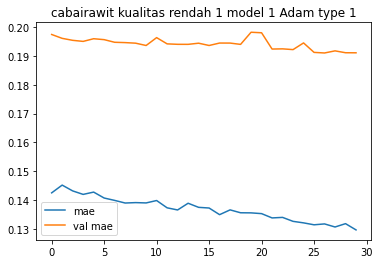

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('cabairawit kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 11ms/step
9373.138 17.767008 11813.71609613165


,actual,prediction
0,53950,37115.796875
1,51650,37037.167969
2,49750,38925.117188
3,49100,38727.468750
4,48050,40245.437500
...,...,...
229,49750,52421.117188
230,60250,52299.242188
231,52400,49954.734375
232,61300,53337.378906


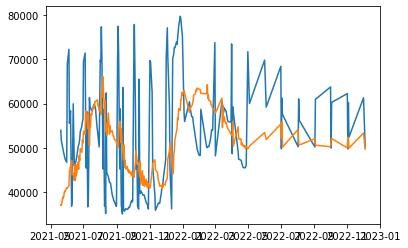

In [ ]:
prediction_a2 = forecast_predict(model_a, test_cabairawit_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_cabairawit_a2 = pd.DataFrame()
# data_new_cabairawit1['date'] = date_test
data_new_cabairawit_a2['actual'] = x_test
data_new_cabairawit_a2['prediction'] = data_result_a2
data_new_cabairawit_a2.to_csv('cabairawit_model1_adam_type3.csv')

plt.plot(y_test, data_new_cabairawit_a2.actual)
plt.plot(y_test, data_new_cabairawit_a2.prediction)
data_new_cabairawit_a2

## model 1

### Adam

In [11]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-trai

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 18s 332ms/step - loss: 0.0500 - mae: 0.1569 - mape: 65.3038 - val_loss: 0.1376 - val_mae: 0.3261 - val_mape: 75.7814
Epoch 2/15
44/44 [==============================] - 14s 312ms/step - loss: 0.0245 - mae: 0.1145 - mape: 80.9614 - val_loss: 0.1152 - val_mae: 0.2977 - val_mape: 77.6068
Epoch 3/15
44/44 [==============================] - 14s 309ms/step - loss: 0.0225 - mae: 0.1125 - mape: 82.4127 - val_loss: 0.0873 - val_mae: 0.2506 - val_mape: 80.6911
Epoch 4/15
44/44 [==============================] - 15s 334ms/step - loss: 0.0228 - mae: 0.1111 - mape: 80.4839 - val_loss: 0.0962 - val_mae: 0.2674 - val_mape: 79.5202
Epoch 5/15
44/44 [==============================] - 14s 310ms/step - loss: 0.0227 - mae: 0.1095 - mape: 77.9199 - val_loss: 0.0969 - val_mae: 0.2685 - val_mape: 79.4452
Epoch 6/15
44/44 [==============================] - 14s 312ms/step - loss: 0.0231 - mae: 0.1109 - mape: 79.2741 - val_loss: 0.0909 - val_mae: 0.2573 - val_

17/17 [==============================] - 0s 15ms/step - loss: 0.0588 - mae: 0.1742 - mape: 31.3316


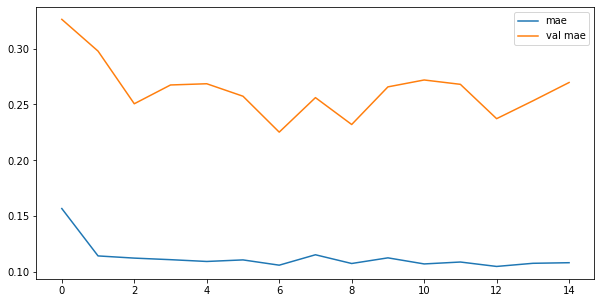

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_cabairawit_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_cabairawit1 = pd.DataFrame()
data_new_cabairawit1['actual'] = x_test
data_new_cabairawit1['prediction'] = data_result1
data_new_cabairawit1.to_csv('cabairawit_model2_adam_type1.csv')

data_new_cabairawit1

131/131 [==============================] - 5s 32ms/step
10881.396 19.347132 13860.497537967387


,actual,prediction
0,53950,38183.128906
1,51650,38360.546875
2,49750,38266.281250
3,49100,38465.695312
4,48050,38388.535156
...,...,...
229,49750,49657.859375
230,60250,49525.179688
231,52400,49620.601562
232,61300,49564.152344


In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_cabairawit1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_cabairawit1['prediction'], '-o')

#### Type 2

In [ ]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 30s 42ms/step - loss: 0.0326 - mae: 0.1398 - mape: 74.0749 - val_loss: 0.0701 - val_mae: 0.2157 - val_mape: 85.9249
Epoch 2/15
718/718 [==============================] - 32s 45ms/step - loss: 0.0308 - mae: 0.1328 - mape: 71.1483 - val_loss: 0.0714 - val_mae: 0.2187 - val_mape: 85.1200
Epoch 3/15
718/718 [==============================] - 30s 42ms/step - loss: 0.0310 - mae: 0.1333 - mape: 72.7965 - val_loss: 0.0766 - val_mae: 0.2319 - val_mape: 82.9931
Epoch 4/15
718/718 [==============================] - 30s 42ms/step - loss: 0.0304 - mae: 0.1320 - mape: 71.1142 - val_loss: 0.0748 - val_mae: 0.2271 - val_mape: 83.2203
Epoch 5/15
718/718 [==============================] - 30s 42ms/step - loss: 0.0293 - mae: 0.1294 - mape: 69.2158 - val_loss: 0.0867 - val_mae: 0.2525 - val_mape: 80.5695
Epoch 6/15
718/718 [==============================] - 30s 42ms/step - loss: 0.0296 - mae: 0.1320 - mape: 71.7223 - val_loss: 0.0750 - val_mae: 0.2258 

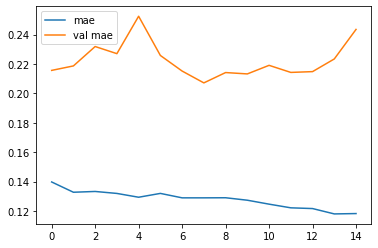

In [ ]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 8ms/step
11278.798 21.63258 13860.497537967387


,actual,prediction
0,53950,40813.550781
1,51650,41994.769531
2,49750,41271.871094
3,49100,42618.789062
4,48050,41122.925781
...,...,...
229,49750,51514.820312
230,60250,51202.164062
231,52400,51804.621094
232,61300,54619.308594


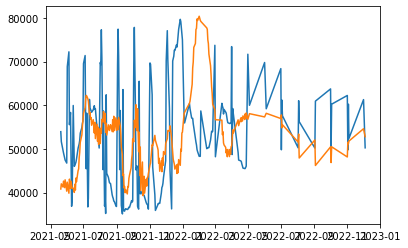

In [ ]:
prediction1_1 = forecast_predict(model1, test_cabairawit_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_cabairawit1_1 = pd.DataFrame()
data_new_cabairawit1_1['actual'] = x_test
data_new_cabairawit1_1['prediction'] = data_result1_1
data_new_cabairawit1_1.to_csv('cabairawit_model2_adam_type2.csv')

plt.plot(y_test, data_new_cabairawit1_1.actual)
plt.plot(y_test, data_new_cabairawit1_1.prediction)
data_new_cabairawit1_1

#### Type 3

In [12]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 39s 337ms/step - loss: 0.0806 - mae: 0.2037 - mape: 76.3373 - val_loss: 0.0687 - val_mae: 0.2127 - val_mape: 87.6882
Epoch 2/15
84/84 [==============================] - 16s 193ms/step - loss: 0.0404 - mae: 0.1543 - mape: 84.4217 - val_loss: 0.0668 - val_mae: 0.2067 - val_mape: 103.5467
Epoch 3/15
84/84 [==============================] - 16s 191ms/step - loss: 0.0397 - mae: 0.1526 - mape: 84.4281 - val_loss: 0.0664 - val_mae: 0.2083 - val_mape: 90.2262
Epoch 4/15
84/84 [==============================] - 17s 203ms/step - loss: 0.0392 - mae: 0.1492 - mape: 81.0001 - val_loss: 0.0651 - val_mae: 0.2044 - val_mape: 92.6707
Epoch 5/15
84/84 [==============================] - 16s 192ms/step - loss: 0.0387 - mae: 0.1485 - mape: 79.1065 - val_loss: 0.0684 - val_mae: 0.2050 - val_mape: 106.6760
Epoch 6/15
84/84 [==============================] - 16s 193ms/step - loss: 0.0394 - mae: 0.1502 - mape: 80.3371 - val_loss: 0.0646 - val_mae: 0.2029 - va

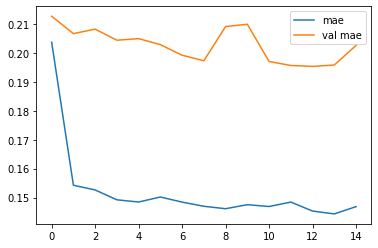

In [13]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 3s 14ms/step
9895.589 18.080225 12721.42885056549


,actual,prediction
0,53950,37230.871094
1,51650,37373.460938
2,49750,37517.046875
3,49100,37779.468750
4,48050,38014.753906
...,...,...
229,49750,49669.203125
230,60250,49636.105469
231,52400,49924.972656
232,61300,50077.933594


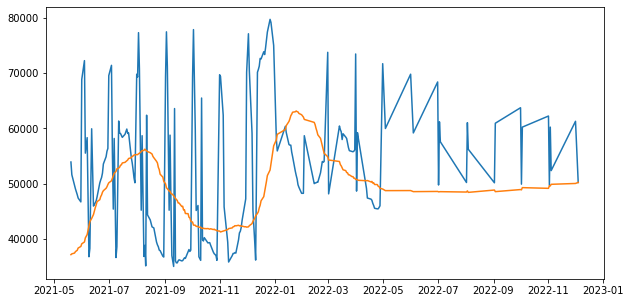

In [14]:
prediction1_2 = forecast_predict(model1, test_cabairawit_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1_2.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_cabairawit1_2 = pd.DataFrame()
data_new_cabairawit1_2['actual'] = x_test
data_new_cabairawit1_2['prediction'] = data_result1_2
data_new_cabairawit1_2.to_csv('cabairawit_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabairawit1_2.actual)
plt.plot(y_test, data_new_cabairawit1_2.prediction)

data_new_cabairawit1_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 19s 342ms/step - loss: 0.0649 - mae: 0.1944 - mape: 84.1119 - val_loss: 0.3603 - val_mae: 0.5440 - val_mape: 85.1707
Epoch 2/15
44/44 [==============================] - 14s 313ms/step - loss: 0.0529 - mae: 0.1621 - mape: 61.2388 - val_loss: 0.3262 - val_mae: 0.5145 - val_mape: 80.5704
Epoch 3/15
44/44 [==============================] - 14s 313ms/step - loss: 0.0446 - mae: 0.1403 - mape: 51.0533 - val_loss: 0.2997 - val_mae: 0.4908 - val_mape: 77.8270
Epoch 4/15
44/44 [==============================] - 14s 313ms/step - loss: 0.0388 - mae: 0.1275 - mape: 49.0902 - val_loss: 0.2793 - val_mae: 0.4727 - val_mape: 76.5626
Epoch 5/15
44/44 [==============================] - 14s 314ms/step - loss: 0.0348 - mae: 0.1213 - mape: 52.9734 - val_loss: 0.2612 - val_mae: 0.4571 - val_mape: 76.2736
Epoch 6/15
44/44 [==============================] - 14s 313ms/step - loss: 0.0319 - mae: 0.1196 - mape: 58.2355 - val_loss: 0.2481 - val_mae: 0.4453 - val_

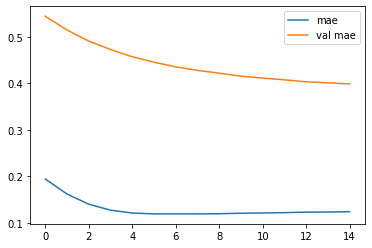

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 5s 32ms/step
12262.873 20.944845 15461.584394880105


,actual,prediction
0,53950,41952.429688
1,51650,41937.554688
2,49750,41945.847656
3,49100,41965.328125
4,48050,41963.675781
...,...,...
229,49750,42993.476562
230,60250,42980.742188
231,52400,42983.554688
232,61300,42997.816406


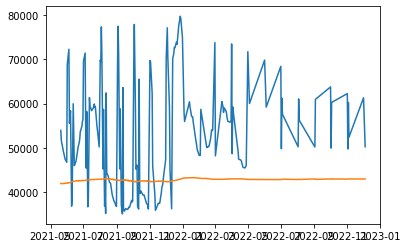

In [ ]:
prediction1_a = forecast_predict(model1_a, test_cabairawit_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_cabairawit1_a = pd.DataFrame()
data_new_cabairawit1_a['actual'] = x_test
data_new_cabairawit1_a['prediction'] = data_result1_a
data_new_cabairawit1_a.to_csv('cabairawit_model2_sgd_type1.csv')


plt.plot(y_test, data_new_cabairawit1_a.actual)
plt.plot(y_test, data_new_cabairawit1_a.prediction)

data_new_cabairawit1_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 29s 41ms/step - loss: 0.0400 - mae: 0.1562 - mape: 84.1626 - val_loss: 0.1543 - val_mae: 0.3465 - val_mape: 75.0361
Epoch 2/15
718/718 [==============================] - 29s 41ms/step - loss: 0.0385 - mae: 0.1544 - mape: 87.5806 - val_loss: 0.1501 - val_mae: 0.3415 - val_mape: 75.1494
Epoch 3/15
718/718 [==============================] - 29s 41ms/step - loss: 0.0380 - mae: 0.1542 - mape: 88.0944 - val_loss: 0.1507 - val_mae: 0.3422 - val_mape: 75.1879
Epoch 4/15
718/718 [==============================] - 31s 42ms/step - loss: 0.0378 - mae: 0.1540 - mape: 88.0650 - val_loss: 0.1479 - val_mae: 0.3388 - val_mape: 75.2461
Epoch 5/15
718/718 [==============================] - 29s 41ms/step - loss: 0.0377 - mae: 0.1533 - mape: 87.1430 - val_loss: 0.1441 - val_mae: 0.3343 - val_mape: 75.4343
Epoch 6/15
718/718 [==============================] - 30s 41ms/step - loss: 0.0376 - mae: 0.1538 - mape: 87.3005 - val_loss: 0.1355 - val_mae: 0.3242 

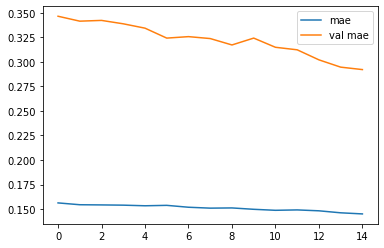

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 10ms/step
10310.617 18.233828 13266.165082645399


,actual,prediction
0,53950,42387.453125
1,51650,42331.628906
2,49750,42404.003906
3,49100,42408.367188
4,48050,42472.511719
...,...,...
229,49750,48003.445312
230,60250,47812.550781
231,52400,48046.031250
232,61300,47914.179688


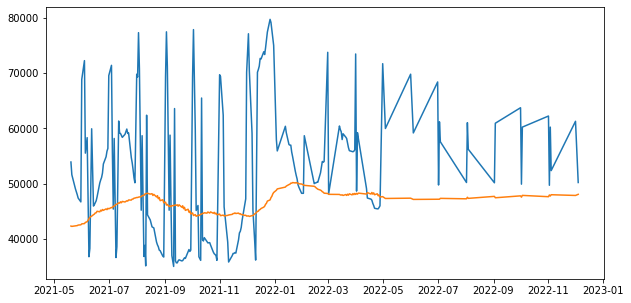

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_cabairawit_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_cabairawit1_a1 = pd.DataFrame()
data_new_cabairawit1_a1['actual'] = x_test
data_new_cabairawit1_a1['prediction'] = data_result1_a1
data_new_cabairawit1_a1.to_csv('cabairawit_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabairawit1_a1.actual)
plt.plot(y_test, data_new_cabairawit1_a1.prediction)
data_new_cabairawit1_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 18s 207ms/step - loss: 0.0476 - mae: 0.1663 - mape: 81.1492 - val_loss: 0.0967 - val_mae: 0.2706 - val_mape: 79.7279
Epoch 2/15
84/84 [==============================] - 17s 207ms/step - loss: 0.0457 - mae: 0.1707 - mape: 91.8430 - val_loss: 0.0900 - val_mae: 0.2582 - val_mape: 80.2862
Epoch 3/15
84/84 [==============================] - 17s 206ms/step - loss: 0.0453 - mae: 0.1736 - mape: 96.8687 - val_loss: 0.0877 - val_mae: 0.2537 - val_mape: 80.6210
Epoch 4/15
84/84 [==============================] - 17s 205ms/step - loss: 0.0451 - mae: 0.1747 - mape: 99.2017 - val_loss: 0.0876 - val_mae: 0.2534 - val_mape: 80.6588
Epoch 5/15
84/84 [==============================] - 18s 207ms/step - loss: 0.0449 - mae: 0.1735 - mape: 97.8364 - val_loss: 0.0857 - val_mae: 0.2494 - val_mape: 80.9451
Epoch 6/15
84/84 [==============================] - 18s 207ms/step - loss: 0.0447 - mae: 0.1743 - mape: 99.4624 - val_loss: 0.0855 - val_mae: 0.2490 - val_

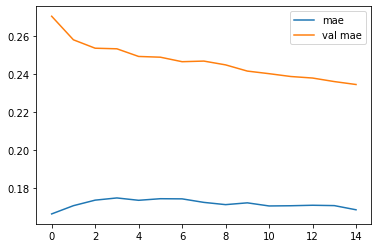

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 3s 15ms/step
9702.846 18.24808 12111.922060515417


,actual,prediction
0,53950,43815.976562
1,51650,43748.500000
2,49750,43845.417969
3,49100,43853.363281
4,48050,43945.324219
...,...,...
229,49750,52145.843750
230,60250,51936.054688
231,52400,52198.308594
232,61300,52057.789062


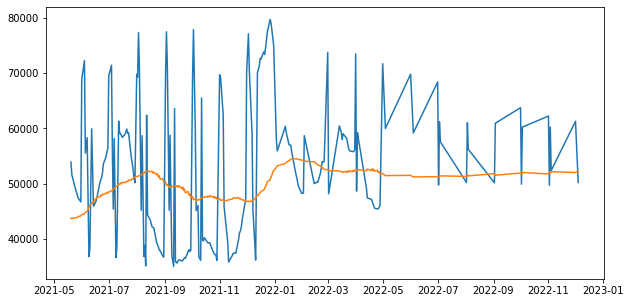

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_cabairawit_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_cabairawit1_a2 = pd.DataFrame()
data_new_cabairawit1_a2['actual'] = x_test
data_new_cabairawit1_a2['prediction'] = data_result1_a2
data_new_cabairawit1_a2.to_csv('cabairawit_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabairawit1_a2.actual)
plt.plot(y_test, data_new_cabairawit1_a2.prediction)

data_new_cabairawit1_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 10s 131ms/step - loss: 0.0696 - mae: 0.2049 - mape: 92.0334 - val_loss: 0.3906 - val_mae: 0.5713 - val_mape: 93.0904
Epoch 2/50
44/44 [==============================] - 5s 109ms/step - loss: 0.0578 - mae: 0.1747 - mape: 69.3595 - val_loss: 0.3565 - val_mae: 0.5405 - val_mape: 84.2192
Epoch 3/50
44/44 [==============================] - 5s 110ms/step - loss: 0.0489 - mae: 0.1505 - mape: 54.8026 - val_loss: 0.3295 - val_mae: 0.5174 - val_mape: 80.9379
Epoch 4/50
44/44 [==============================] - 7s 159ms/step - loss: 0.0426 - mae: 0.1342 - mape: 48.8919 - val_loss: 0.3078 - val_mae: 0.4981 - val_mape: 78.7108
Epoch 5/50
44/44 [==============================] - 5s 110ms/step - loss: 0.0381 - mae: 0.1258 - mape: 49.6193 - val_loss: 0.2902 - val_mae: 0.4820 - val_mape: 76.9033
Epoch 6/50
44/44 [==============================] - 5s 108ms/step - loss: 0.0349 - mae: 0.1219 - mape: 53.3803 - val_loss: 0.2758 - val_mae: 0.4696 - val_mape:

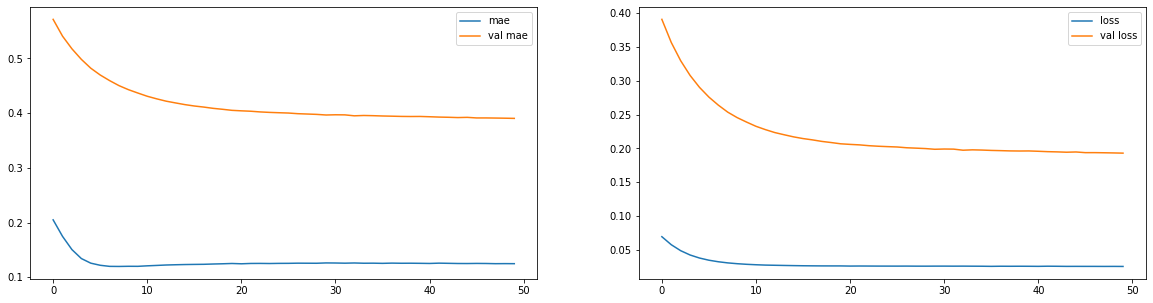

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 3s 15ms/step
12014.327 20.668064 15097.209278538865


,actual,prediction
0,53950,42147.679688
1,51650,42107.562500
2,49750,42155.750000
3,49100,42206.460938
4,48050,42208.121094
...,...,...
229,49750,43635.335938
230,60250,43625.621094
231,52400,43653.414062
232,61300,43631.664062


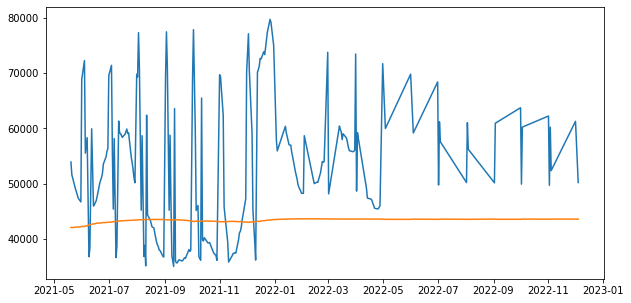

In [ ]:
prediction2 = forecast_predict(model2, test_cabairawit_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_cabairawit2 = pd.DataFrame()
data_new_cabairawit2['actual'] = x_test
data_new_cabairawit2['prediction'] = data_result2
data_new_cabairawit2.to_csv('cabairawit_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabairawit2.actual)
plt.plot(y_test, data_new_cabairawit2.prediction)
data_new_cabairawit2

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 14s 20ms/step - loss: 0.0405 - mae: 0.1558 - mape: 83.7629 - val_loss: 0.1486 - val_mae: 0.3391 - val_mape: 74.9013
Epoch 2/50
718/718 [==============================] - 14s 20ms/step - loss: 0.0388 - mae: 0.1553 - mape: 87.9814 - val_loss: 0.1442 - val_mae: 0.3336 - val_mape: 75.0011
Epoch 3/50
718/718 [==============================] - 14s 20ms/step - loss: 0.0382 - mae: 0.1540 - mape: 87.5176 - val_loss: 0.1386 - val_mae: 0.3272 - val_mape: 75.3978
Epoch 4/50
718/718 [==============================] - 14s 20ms/step - loss: 0.0378 - mae: 0.1537 - mape: 87.5292 - val_loss: 0.1379 - val_mae: 0.3265 - val_mape: 75.4758
Epoch 5/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0376 - mae: 0.1536 - mape: 87.0440 - val_loss: 0.1354 - val_mae: 0.3237 - val_mape: 75.6905
Epoch 6/50
718/718 [==============================] - 14s 20ms/step - loss: 0.0373 - mae: 0.1527 - mape: 86.2789 - val_loss: 0.1319 - val_mae: 0.3195 

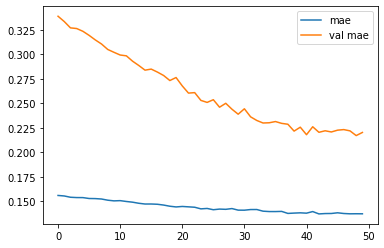

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_cabairawit_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_cabairawit2_1 = pd.DataFrame()
data_new_cabairawit2_1['actual'] = x_test
data_new_cabairawit2_1['prediction'] = data_result2_1
data_new_cabairawit2_1.to_csv('cabairawit_model3_sgd_type2.csv')

data_new_cabairawit2

199/199 [==============================] - 1s 5ms/step
10008.293 18.553736 12546.425148224493


,actual,prediction
0,53950,42147.679688
1,51650,42107.562500
2,49750,42155.750000
3,49100,42206.460938
4,48050,42208.121094
...,...,...
229,49750,43635.335938
230,60250,43625.621094
231,52400,43653.414062
232,61300,43631.664062


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 6s 73ms/step - loss: 0.0422 - mae: 0.1535 - mape: 77.0999 - val_loss: 0.0699 - val_mae: 0.2149 - val_mape: 86.0657
Epoch 2/50
84/84 [==============================] - 6s 72ms/step - loss: 0.0408 - mae: 0.1567 - mape: 83.2207 - val_loss: 0.0687 - val_mae: 0.2132 - val_mape: 87.1800
Epoch 3/50
84/84 [==============================] - 6s 73ms/step - loss: 0.0405 - mae: 0.1573 - mape: 86.2912 - val_loss: 0.0680 - val_mae: 0.2122 - val_mape: 87.8722
Epoch 4/50
84/84 [==============================] - 6s 73ms/step - loss: 0.0402 - mae: 0.1562 - mape: 86.0072 - val_loss: 0.0677 - val_mae: 0.2118 - val_mape: 88.1558
Epoch 5/50
84/84 [==============================] - 6s 73ms/step - loss: 0.0400 - mae: 0.1563 - mape: 85.7486 - val_loss: 0.0675 - val_mae: 0.2113 - val_mape: 88.4725
Epoch 6/50
84/84 [==============================] - 6s 73ms/step - loss: 0.0401 - mae: 0.1570 - mape: 87.3120 - val_loss: 0.0673 - val_mae: 0.2110 - val_mape: 88.678

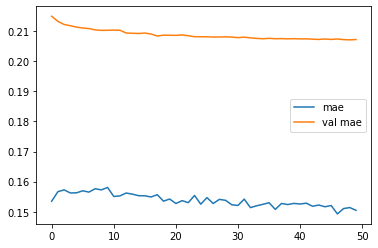

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_cabairawit_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_cabairawit2_2 = pd.DataFrame()
data_new_cabairawit2_2['actual'] = x_test
data_new_cabairawit2_2['prediction'] = data_result2_2
data_new_cabairawit2_2.to_csv('cabairawit_model3_sgd-type3.csv')

data_new_cabairawit2_2

181/181 [==============================] - 1s 8ms/step
9918.283 19.304047 12119.632337657773


,actual,prediction
0,53950,40774.835938
1,51650,40886.238281
2,49750,40869.578125
3,49100,40799.449219
4,48050,41142.558594
...,...,...
229,49750,54638.843750
230,60250,54477.617188
231,52400,54381.171875
232,61300,55066.066406


### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 10s 143ms/step - loss: 0.0472 - mae: 0.1485 - mape: 59.0272 - val_loss: 0.2033 - val_mae: 0.3996 - val_mape: 75.4212
Epoch 2/50
44/44 [==============================] - 5s 124ms/step - loss: 0.0227 - mae: 0.1171 - mape: 87.6686 - val_loss: 0.1723 - val_mae: 0.3643 - val_mape: 74.8478
Epoch 3/50
44/44 [==============================] - 5s 121ms/step - loss: 0.0221 - mae: 0.1103 - mape: 78.4470 - val_loss: 0.1515 - val_mae: 0.3391 - val_mape: 75.1022
Epoch 4/50
44/44 [==============================] - 5s 122ms/step - loss: 0.0230 - mae: 0.1143 - mape: 83.4668 - val_loss: 0.1413 - val_mae: 0.3265 - val_mape: 75.5693
Epoch 5/50
44/44 [==============================] - 5s 121ms/step - loss: 0.0216 - mae: 0.1095 - mape: 79.3872 - val_loss: 0.1549 - val_mae: 0.3429 - val_mape: 74.9797
Epoch 6/50
44/44 [==============================] - 5s 122ms/step - loss: 0.0221 - mae: 0.1113 - mape: 81.7795 - val_loss: 0.1423 - val_mae: 0.3275 - val_mape:

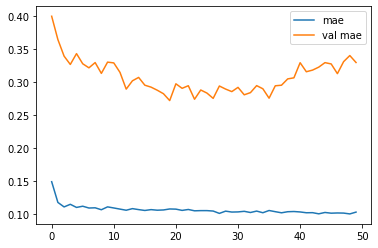

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_cabairawit_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_cabairawit2_a = pd.DataFrame()
data_new_cabairawit2_a['actual'] = x_test
data_new_cabairawit2_a['prediction'] = data_result2_a
data_new_cabairawit2_a.to_csv('cabairawit_model3_adam-type1.csv')

data_new_cabairawit2_a

131/131 [==============================] - 3s 16ms/step
11572.979 20.640656 14318.390412333363


,actual,prediction
0,53950,38999.062500
1,51650,38873.691406
2,49750,38990.089844
3,49100,39216.035156
4,48050,39019.617188
...,...,...
229,49750,49276.695312
230,60250,49355.359375
231,52400,49360.660156
232,61300,49317.570312


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0342 - mae: 0.1426 - mape: 76.1415 - val_loss: 0.1171 - val_mae: 0.2979 - val_mape: 77.2241
Epoch 2/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0340 - mae: 0.1430 - mape: 77.6839 - val_loss: 0.0912 - val_mae: 0.2571 - val_mape: 79.8778
Epoch 3/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0330 - mae: 0.1405 - mape: 76.8852 - val_loss: 0.0873 - val_mae: 0.2524 - val_mape: 80.0879
Epoch 4/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0323 - mae: 0.1392 - mape: 76.1604 - val_loss: 0.0761 - val_mae: 0.2289 - val_mape: 81.9304
Epoch 5/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0311 - mae: 0.1359 - mape: 73.9193 - val_loss: 0.0727 - val_mae: 0.2213 - val_mape: 82.8743
Epoch 6/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0316 - mae: 0.1376 - mape: 76.0395 - val_loss: 0.0639 - val_mae: 0.2043 

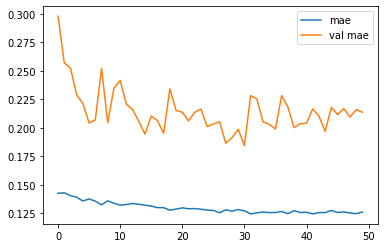

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 5ms/step
10052.151 19.861198 11958.322959345094


,actual,prediction
0,53950,40618.457031
1,51650,40899.175781
2,49750,40854.140625
3,49100,40545.660156
4,48050,40751.281250
...,...,...
229,49750,54599.285156
230,60250,56802.835938
231,52400,55766.328125
232,61300,56988.382812


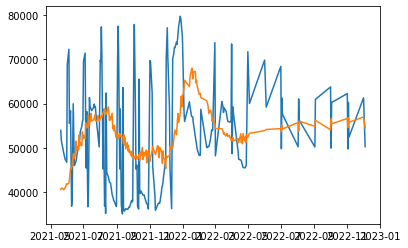

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_cabairawit_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_cabairawit2_a1 = pd.DataFrame()
data_new_cabairawit2_a1['actual'] = x_test
data_new_cabairawit2_a1['prediction'] = data_result2_a1
data_new_cabairawit2_a1.to_csv('cabairawit_model3_adam-type2.csv')

plt.plot(y_test, data_new_cabairawit2_a1.actual)
plt.plot(y_test, data_new_cabairawit2_a1.prediction)
data_new_cabairawit2_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 7s 81ms/step - loss: 0.0362 - mae: 0.1392 - mape: 68.7332 - val_loss: 0.0627 - val_mae: 0.1956 - val_mape: 92.4854
Epoch 2/50
84/84 [==============================] - 7s 81ms/step - loss: 0.0348 - mae: 0.1430 - mape: 79.9611 - val_loss: 0.0636 - val_mae: 0.2021 - val_mape: 90.4669
Epoch 3/50
84/84 [==============================] - 7s 82ms/step - loss: 0.0353 - mae: 0.1399 - mape: 73.0132 - val_loss: 0.0632 - val_mae: 0.2002 - val_mape: 91.3502
Epoch 4/50
84/84 [==============================] - 7s 80ms/step - loss: 0.0347 - mae: 0.1386 - mape: 73.7417 - val_loss: 0.0626 - val_mae: 0.1978 - val_mape: 92.7250
Epoch 5/50
84/84 [==============================] - 7s 81ms/step - loss: 0.0342 - mae: 0.1392 - mape: 72.8407 - val_loss: 0.0626 - val_mae: 0.1912 - val_mape: 95.7905
Epoch 6/50
84/84 [==============================] - 7s 81ms/step - loss: 0.0344 - mae: 0.1400 - mape: 74.8722 - val_loss: 0.0627 - val_mae: 0.1922 - val_mape: 96.663

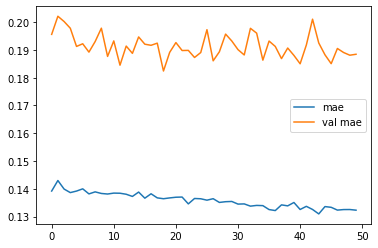

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 8ms/step
11339.965 23.278595 14289.0285184123


,actual,prediction
0,53950,39976.355469
1,51650,39756.980469
2,49750,40009.800781
3,49100,40288.613281
4,48050,40064.851562
...,...,...
229,49750,49973.269531
230,60250,49726.464844
231,52400,49598.160156
232,61300,49444.523438


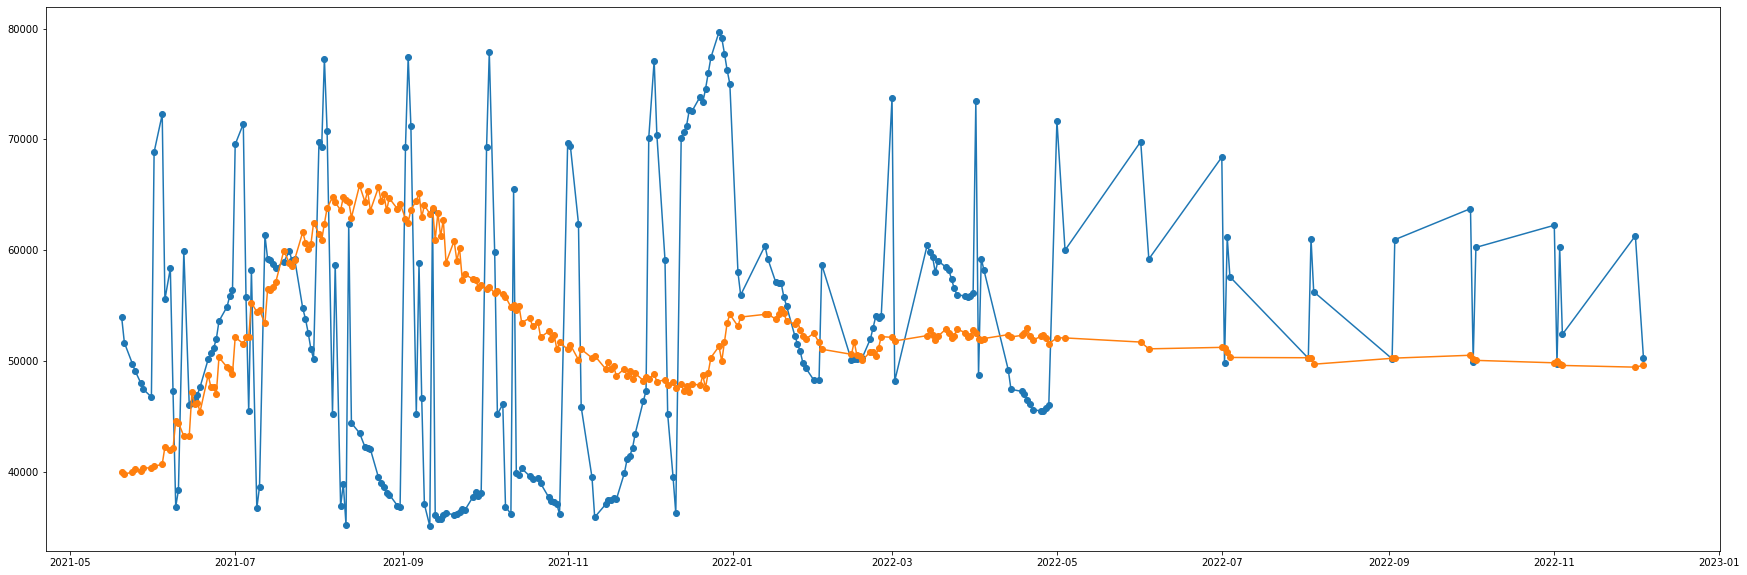

In [ ]:
prediction2_a2 = forecast_predict(model2_a, test_cabairawit_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_cabairawit2_a2 = pd.DataFrame()
data_new_cabairawit2_a2['actual'] = x_test
data_new_cabairawit2_a2['prediction'] = data_result2_a2
data_new_cabairawit2_a2.to_csv('cabairawit_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_cabairawit2_a2.actual, '-o')
plt.plot(y_test,data_new_cabairawit2_a2.prediction, '-o')
data_new_cabairawit2_a2